[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/00_preprocesamiento_dataset_clasificacion.ipynb)



# EDA preliminar de los datos preprocesados unificados

## Objetivo a desarrollar

To do...

## Actividades

En este notebook se va a intentar realizar las siguientes tareas relacionadas con la EDA simple:
- [x] Obtención de la caracteristica RMS

## 1. Librerias y configuraciones previas


In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

try:
    import mlflow
    print("La librería 'mlflow' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'mlflow' no está instalada.")
    print("Instalando 'mlflow'...")
    !pip install mlflow

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.
La librería 'mlflow' está instalada y se ha importado correctamente.


In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal


In [3]:
import requests
from tqdm import tqdm
import os
import zipfile
import sys

In [4]:
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor
from libemg import filtering

## 2. Funciones

In [5]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
# from utils.funciones1 import multiple_plot
# from utils.funciones2 import test_hola, graficar_medida, graficar_medida2, filter_signal, \
#                             segmentar_data_base, aplanar_data_base, aplanar_ventana, \
#                             rms_value, mav_value, features_data_base

def find_value_ranges(arr, value):
    """
    Encuentra los rangos (inicio, fin) donde el valor dado aparece de forma continua en un array.

    Parámetros:
        arr (array-like): arreglo de entrada (lista o np.array).
        value (int o float): valor objetivo para encontrar bloques contiguos.

    Retorna:
        List[Tuple[int, int]]: lista de tuplas (inicio, fin) donde aparecen bloques del valor.
    """
    arr = np.asarray(arr)
    ranges = []
    in_range = False

    for i, val in enumerate(arr):
        if val == value and not in_range:
            start = i
            in_range = True
        elif val != value and in_range:
            end = i - 1
            ranges.append((start, end))
            in_range = False

    # Si termina en un bloque del valor
    if in_range:
        ranges.append((start, len(arr) - 1))

    return ranges

## 3. Carga y preprocesamiento del dataset original

Configuración inicial

In [6]:
# Agregar el directorio raíz del proyecto al PYTHONPATH
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Sube un nivel
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
print(f"Directorio raíz del proyecto agregado al PYTHONPATH: {ROOT_DIR}")

Directorio raíz del proyecto agregado al PYTHONPATH: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia


In [7]:
# se importan las rutas
# from globals import SRC_DIR, DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR
# Agregar el directorio SRC_DIR al PYTHONPATH
#if SRC_DIR not in sys.path:
#    sys.path.append(SRC_DIR)
from globals import PREPROCESSED_SUBSET_DATA_DIR, FEATURES_SUBSET_DATA_DIR
print(f"Ruta de subconjunto de datos filtrados: {PREPROCESSED_SUBSET_DATA_DIR}")
print(f"Ruta de subconjunto de las caracteristicas: {FEATURES_SUBSET_DATA_DIR}")

Ruta de subconjunto de datos filtrados: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\preprocessed_subset
Ruta de subconjunto de las caracteristicas: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset


### Formato de los datos

En nuestro analisis, solo nos va a interesar los datos de las columnas:
* **`emg`**: Señales EMG superficiales tomadas de los 10 electronos.
* **`rerepetition`**: Repetición de la postura de la mano (ejercicio) realizado. Cada postura se repetira 10 veces.
* **`restimulus`**: Postura manual (ejercicio) realizada.

Es importante anotar que los datos cargados son matrices cuyas columnas se relacionan con la información de la siguiente forma:

```
[ emg | restimulus | rerepetition ] = [ 0:9 | 10 | 11 ]
```

### Carga de datos y combinación de los datos

Los datos de cada sujeto se cargan y combianan en el diccionario `raw_data`

In [8]:
# Listar y cargar los archivos .npy del directorio PROCESSED_DATA_DIR
npy_files = [f for f in os.listdir(PREPROCESSED_SUBSET_DATA_DIR) if f.endswith('.npy')]

data = {}
for file in npy_files:
    file_path = os.path.join(PREPROCESSED_SUBSET_DATA_DIR, file)
    sub_i = file.split('_s')[-1].split('.')[0]
    sub_i = sub_i.split('_')[0]
    data[sub_i] = np.load(file_path)
    print(f"Archivo cargado: {file}")

Archivo cargado: preprocessed_subset_s10_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s11_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s12_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s13_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s14_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s15_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s16_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s17_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s18_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s19_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s1_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s20_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s21_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s22_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s23_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s24_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s25_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s26_p1_23_E3.npy
Archivo cargado: preprocessed

Se realiza la ejecición de algunos comandos de inspección:

In [9]:
len(data)  # Mostrar la cantidad de archivos cargados

27

In [10]:
data['1'].shape

(16036, 12)

Según lo anterior, al parecer la carga de datos parece correcta.

Nuevamente, vamos a realizar una inspección visual de los datos cargados usando un sujeto como muestra (sujeto 1)

```
[ emg | restimulus | rerepetition ] = [ 0:9 | 10 | 11 ]
```

* **`restimulus`**: 1 - 23 (El reposo se toma como 0)
* **`rerepetition`**: 1 - 10

In [11]:
INDEX_SUB = '1'
emg_s1 = data[INDEX_SUB][:,0:10]
restimulus_s1 = data[INDEX_SUB][:,10]
rerepetition_s1 = data[INDEX_SUB][:,11]

Vamos a graficar todas los ejercicios para el usuario seleccionado

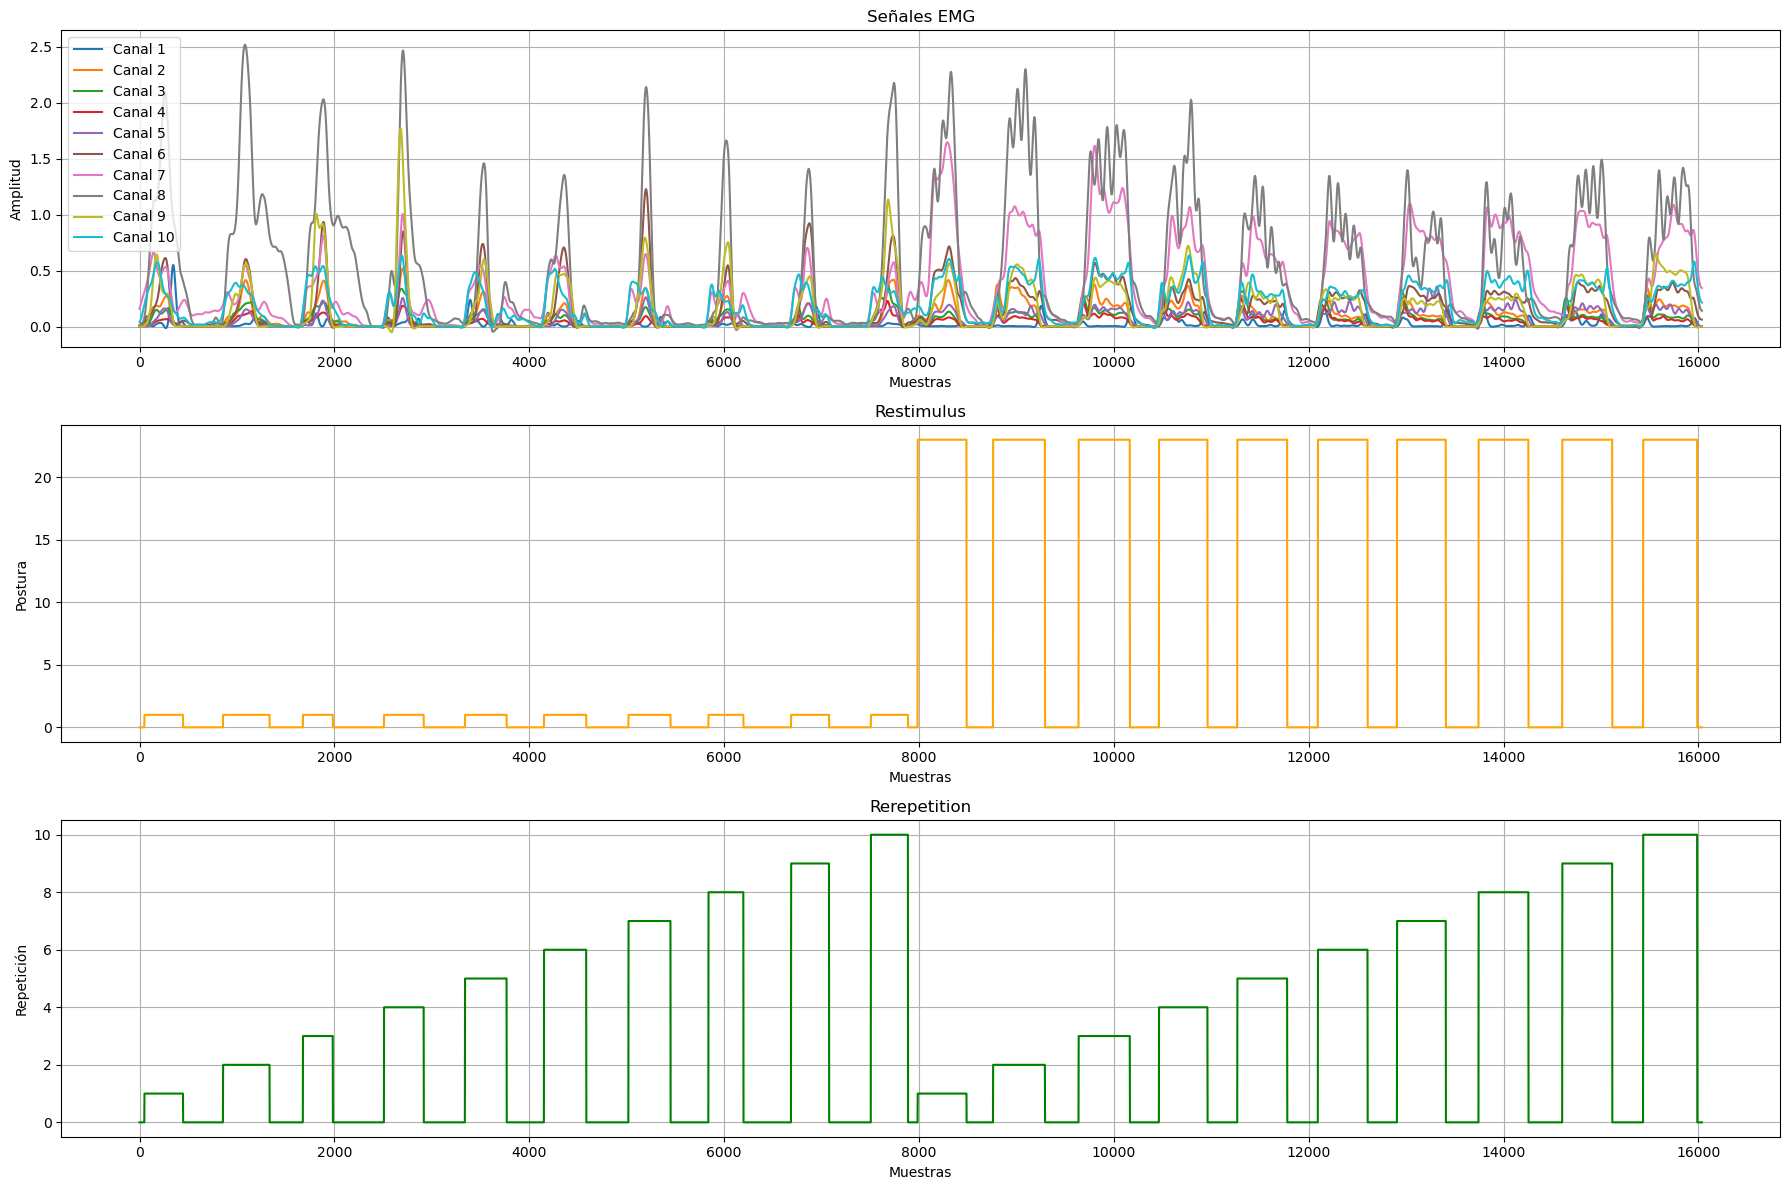

In [12]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1, color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1, color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [13]:
data[INDEX_SUB].shape  # Mostrar la forma de los datos cargados

(16036, 12)

## 3. Extracción de caracteristicas

### Concatenación de todos los datos en un unico dataframe

Se pasan todos los datos del diccionario en el que se cargaron los datos  (`raw_data`) a un unica matriz para facilitar la analitica de estos. Esta matriz tendra como primera columna el numero del sujeto, las columnas de esta matriz seran:


```
[ subject | emg | restimulus | rerepetition ] = [ 0 | 1:10 | 11 | 12 ]
```

In [14]:
def concatenar_matrices_con_clave(diccionario_matrices):
    """
    Concatena verticalmente las matrices en un diccionario, 
    agregando una columna a la izquierda con el valor entero de la clave asociada a cada matriz.

    Parámetros:
    diccionario_matrices (dict): Diccionario cuyas claves son cadenas de dígitos ('1', '2', ...) 
                                  y cuyos valores son matrices numpy de igual número de columnas.

    Retorna:
    numpy.ndarray: Una única matriz numpy con una columna adicional al principio que identifica la clave original.
    """
    matrices_modificadas = []

    for k, matriz in diccionario_matrices.items():
        clave_int = int(k)
        n_filas = matriz.shape[0]
        columna_clave = np.full((n_filas, 1), clave_int)
        matriz_modificada = np.hstack((columna_clave, matriz))
        matrices_modificadas.append(matriz_modificada)

    return np.concatenate(matrices_modificadas, axis=0)

Invocación de la función

In [15]:
all_users_data = concatenar_matrices_con_clave(data)
all_users_data.shape  # Mostrar la forma de los datos concatenados

(432383, 13)

Se seleccinan de manera aleatoria 5 muestras para verificar consistencia de la matrix:

In [16]:
# Seleccionar una muestra aleatoria de 20 filas
SAMPLES = 5
sample_data = all_users_data[np.random.choice(all_users_data.shape[0], SAMPLES, replace=False)]

# Mostrar la muestra seleccionada
print(sample_data)

[[ 1.30000000e+01  3.58718735e-01  3.79685839e-01  6.78899910e-01
   1.24267782e-02  5.91869353e-03  4.16451905e-02  4.16976111e-01
   7.49441651e-01  2.57267692e-01  4.60022203e-01  2.30000000e+01
   7.00000000e+00]
 [ 9.00000000e+00  6.17363032e-02  1.18319580e-02 -5.23813724e-04
   4.16081677e-03  1.67320665e-03  1.07846021e-01  1.51336222e-01
   4.25703476e-02 -8.67880866e-03 -3.83296201e-03  1.00000000e+00
   3.00000000e+00]
 [ 1.70000000e+01  3.79986814e-01  4.82539060e-03  1.14356529e-03
  -1.99806463e-03  4.18240876e-03  2.97976988e-02  1.61444040e-01
   4.53336039e-01  8.37407567e-04  1.43457599e-01  0.00000000e+00
   0.00000000e+00]
 [ 2.50000000e+01  4.23730379e-03  2.21884059e-03  7.45113879e-03
   8.47716240e-03  1.21368814e-02  1.37333301e-01  1.99693758e-01
   3.21206671e-01  2.88316319e-03  2.34009556e-01  0.00000000e+00
   0.00000000e+00]
 [ 1.90000000e+01  9.89812115e-01  5.32845521e-01  8.00431308e-01
   7.55690467e-03  6.39006289e-03  2.07508873e-03  7.67145345e-02


Al parecer, la salida tiene sentido de modo que se puede proceder con la creación del dataframe `df_all_users` a partir de la matriz `all_users_raw_data`

In [17]:
# Crear un DataFrame a partir de all_users_raw_data
columns = ['subject'] + [f'emg_{i}' for i in range(1, 11)] + ['restimulus', 'rerepetition']
df_all_users = pd.DataFrame(all_users_data, columns=columns)

# Mostrar las primeras filas del DataFrame
df_all_users.head()

,subject,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,restimulus,rerepetition
0,10.0,0.247590,0.101654,-0.004054,0.002397,0.002365,0.002183,-0.005319,-0.027150,0.002326,-0.021768,0.0,0.0
1,10.0,0.242329,0.098765,-0.004391,0.002396,0.002362,0.002181,-0.005193,-0.027887,0.002318,-0.022504,0.0,0.0
2,10.0,0.237068,0.095835,-0.004730,0.002395,0.002359,0.002180,-0.005026,-0.028523,0.002309,-0.023206,0.0,0.0
3,10.0,0.231825,0.092875,-0.005072,0.002394,0.002356,0.002179,-0.004812,-0.029049,0.002300,-0.023867,0.0,0.0
4,10.0,0.226615,0.089892,-0.005416,0.002392,0.002353,0.002180,-0.004550,-0.029451,0.002291,-0.024482,0.0,0.0


### Descripción general del dataframe

#### Inspección inicial

In [18]:
df_all_users.shape  # Mostrar la forma de los datos concatenados

(432383, 13)

In [19]:
df_all_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432383 entries, 0 to 432382
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   subject       432383 non-null  float64
 1   emg_1         432383 non-null  float64
 2   emg_2         432383 non-null  float64
 3   emg_3         432383 non-null  float64
 4   emg_4         432383 non-null  float64
 5   emg_5         432383 non-null  float64
 6   emg_6         432383 non-null  float64
 7   emg_7         432383 non-null  float64
 8   emg_8         432383 non-null  float64
 9   emg_9         432383 non-null  float64
 10  emg_10        432383 non-null  float64
 11  restimulus    432383 non-null  float64
 12  rerepetition  432383 non-null  float64
dtypes: float64(13)
memory usage: 42.9 MB


Como hay columnas que tienen que ver con datos categoricos y el dataframe original tiene todos los datos numericos, se hace la conversión de las columnas categoricas cargadas como numericas a datos categoricos.

In [20]:
# Convertir las columnas en categóricas
df_all_users['subject'] = df_all_users['subject'].astype('category')
df_all_users['restimulus'] = df_all_users['restimulus'].astype('category')
df_all_users['rerepetition'] = df_all_users['rerepetition'].astype('category')

# Verificar los cambios
df_all_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432383 entries, 0 to 432382
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   subject       432383 non-null  category
 1   emg_1         432383 non-null  float64 
 2   emg_2         432383 non-null  float64 
 3   emg_3         432383 non-null  float64 
 4   emg_4         432383 non-null  float64 
 5   emg_5         432383 non-null  float64 
 6   emg_6         432383 non-null  float64 
 7   emg_7         432383 non-null  float64 
 8   emg_8         432383 non-null  float64 
 9   emg_9         432383 non-null  float64 
 10  emg_10        432383 non-null  float64 
 11  restimulus    432383 non-null  category
 12  rerepetition  432383 non-null  category
dtypes: category(3), float64(10)
memory usage: 34.2 MB


### Segmentación

La segmentación consiste en extraer porciones de la señal mediante ventanas de tiempo (que pueden ir sobrelapadas o no) para realizar una analisis local mas focalizado. La siguiente figura resume el procedimiento:

![overlap_win](overlap_window.png)

La segmentación se realiza tomando ventanas de 30 muestras de tamaño con un sobrelapamiento de 10 muestras. Antes de intentar generalizar el procedimiento, vamos a realizar la prueba con los datos asociados al primer sujeto:

```py
INDEX_SUB = '1'
emg_s1 = filtered_data[INDEX_SUB][:,0:10]
restimulus_s1 = filtered_data[INDEX_SUB][:,10]
rerepetition_s1 = filtered_data[INDEX_SUB][:,11]
```

In [21]:
from libemg.utils import get_windows

##### Datos categoricos

In [22]:
data[INDEX_SUB].shape

(16036, 12)

In [23]:
# Mostrar las primeras 10 filas de los datos filtrados para el sujeto especificado en INDEX_SUB
data[INDEX_SUB][:10]

array([[-1.10901571e-03,  3.35777718e-04,  2.29754608e-03,
         2.41791565e-03,  2.46656592e-03,  1.17058176e-02,
         1.57929216e-01,  1.22639163e-02,  1.38498726e-03,
         4.04043369e-02,  0.00000000e+00,  0.00000000e+00],
       [-1.04112299e-03,  2.49932580e-04,  2.28240912e-03,
         2.42312377e-03,  2.49875419e-03,  1.23512526e-02,
         1.60794013e-01,  1.24751146e-02,  1.31715902e-03,
         4.16480950e-02,  0.00000000e+00,  0.00000000e+00],
       [-9.61654668e-04,  1.64989863e-04,  2.26635120e-03,
         2.42849756e-03,  2.53352570e-03,  1.30167117e-02,
         1.63716897e-01,  1.26969245e-02,  1.24749988e-03,
         4.29711090e-02,  0.00000000e+00,  0.00000000e+00],
       [-8.69611219e-04,  8.13842298e-05,  2.24935306e-03,
         2.43401448e-03,  2.57097691e-03,  1.37016696e-02,
         1.66695644e-01,  1.29299952e-02,  1.17612738e-03,
         4.43763017e-02,  0.00000000e+00,  0.00000000e+00],
       [-7.63940749e-04, -4.14786429e-07,  2.2313975

In [24]:
# Split the raw EMG into windows
windows_s1 = get_windows(data[INDEX_SUB], 30, 20)
windows_s1.shape  # Mostrar la forma de las ventanas de datos

(801, 12, 30)

Segun el resultado anterior, se generaron 801 segmentos de 30 muestras para cada una de las 12 señales (`emg`, `restimulus` y `rerepetition`). Cada una de estas ventanas presentaban un solapamiento de 10 entre ellas:

In [25]:
windows_s1[0].shape

(12, 30)

Ahora se muestran los datos asociados a las primeras `3` muestras de la ventana `0`:

In [26]:
windows_s1[0,:,:3]  # 

array([[-0.00110902, -0.00104112, -0.00096165],
       [ 0.00033578,  0.00024993,  0.00016499],
       [ 0.00229755,  0.00228241,  0.00226635],
       [ 0.00241792,  0.00242312,  0.0024285 ],
       [ 0.00246657,  0.00249875,  0.00253353],
       [ 0.01170582,  0.01235125,  0.01301671],
       [ 0.15792922,  0.16079401,  0.1637169 ],
       [ 0.01226392,  0.01247511,  0.01269692],
       [ 0.00138499,  0.00131716,  0.0012475 ],
       [ 0.04040434,  0.04164809,  0.04297111],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

Como se puede ver, las dos últimas filas tienen que ver las señales asociadas al tag del ejercicio. Miremos la transpuesta para tener una idea mas clara.

In [27]:
windows_s1_T = windows_s1[0].T
windows_s1_T[0:3,:]  # Mostrar las primeras filas y columnas de la primera ventana transpuesta

array([[-0.00110902,  0.00033578,  0.00229755,  0.00241792,  0.00246657,
         0.01170582,  0.15792922,  0.01226392,  0.00138499,  0.04040434,
         0.        ,  0.        ],
       [-0.00104112,  0.00024993,  0.00228241,  0.00242312,  0.00249875,
         0.01235125,  0.16079401,  0.01247511,  0.00131716,  0.04164809,
         0.        ,  0.        ],
       [-0.00096165,  0.00016499,  0.00226635,  0.0024285 ,  0.00253353,
         0.01301671,  0.1637169 ,  0.01269692,  0.0012475 ,  0.04297111,
         0.        ,  0.        ]])

Según lo anterior, a lo que se le debe sacar la feature es a las primeras 10 filas de la ventana. A continuación se muestran las 10 señales emg para las tres primeras muestras de la ventana:

In [28]:
windows_s1[0,:10,:3]

array([[-0.00110902, -0.00104112, -0.00096165],
       [ 0.00033578,  0.00024993,  0.00016499],
       [ 0.00229755,  0.00228241,  0.00226635],
       [ 0.00241792,  0.00242312,  0.0024285 ],
       [ 0.00246657,  0.00249875,  0.00253353],
       [ 0.01170582,  0.01235125,  0.01301671],
       [ 0.15792922,  0.16079401,  0.1637169 ],
       [ 0.01226392,  0.01247511,  0.01269692],
       [ 0.00138499,  0.00131716,  0.0012475 ],
       [ 0.04040434,  0.04164809,  0.04297111]])

In [29]:
# Extraer las primeras 10 filas de todos los segmentos
emg_s1 = windows_s1[:, :10, :]

In [30]:
emg_s1.shape

(801, 10, 30)

Veamos esto para el segmento 0:

In [31]:
emg_s1[0,:,:3]

array([[-0.00110902, -0.00104112, -0.00096165],
       [ 0.00033578,  0.00024993,  0.00016499],
       [ 0.00229755,  0.00228241,  0.00226635],
       [ 0.00241792,  0.00242312,  0.0024285 ],
       [ 0.00246657,  0.00249875,  0.00253353],
       [ 0.01170582,  0.01235125,  0.01301671],
       [ 0.15792922,  0.16079401,  0.1637169 ],
       [ 0.01226392,  0.01247511,  0.01269692],
       [ 0.00138499,  0.00131716,  0.0012475 ],
       [ 0.04040434,  0.04164809,  0.04297111]])

### Extracción de caracteristicas

In [32]:
from libemg.feature_extractor import FeatureExtractor

fe = FeatureExtractor()

In [33]:
feature_list1 = ['RMS']

In [34]:
features_s1 = fe.extract_features(feature_list1, emg_s1)
features_s1.keys()

dict_keys(['RMS'])

In [35]:
features_s1['RMS'].shape  # Mostrar la forma de las características extraídas

(801, 10)

Vemos que se tiene le valor RMS para cada uno de los canales, esto relacionado con las 801 ventanas. A continuación vamos a mostrar los valores RMS para de todas las señales sEMG para los 3 primeros segmentos:

In [36]:
features_s1['RMS'][0:3]  # Mostrar las primeras filas y columnas de las características extraídas

array([[0.00440766, 0.00042322, 0.0019679 , 0.00250594, 0.00341307,
        0.02393885, 0.20610223, 0.01844022, 0.00067767, 0.07467822],
       [0.02349061, 0.00587794, 0.00146186, 0.00262896, 0.00549564,
        0.03718825, 0.26740832, 0.04344034, 0.00141234, 0.14213795],
       [0.06138584, 0.02611376, 0.00260215, 0.00267404, 0.00702446,
        0.04432762, 0.32245441, 0.12288303, 0.01137533, 0.21592697]])

Vamos ahora con los tags

In [37]:
# Extraer las primeras 2 ultimas filas de todos los segmentos
restimulus_s1 = windows_s1[:, 10, :]
restimulus_s1.shape  # Mostrar la forma de las etiquetas extraídas

(801, 30)

A continuación, visualizamos los tags para los tres primeros segmentos (`restimulus` y `rerepetition`)

In [38]:
restimulus_s1[:2,:]  # Mostrar las primeras filas y columnas de las etiquetas extraídas

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Con el fin de colocar aquellos segmentos donde hay un cambio de nivel en el estimulo se va a crear un array donde cada fila tiene el valor del estimulo si todas las columnas son iguales, de lo contrario -1 para indicar que en ese segmento hubo un cambio de nivel

In [39]:
processed_restimulus_s1 = np.where(np.all(restimulus_s1 == restimulus_s1[:, [0]], axis=1), restimulus_s1[:, 0], -1)

# Mostrar el resultado
processed_restimulus_s1

array([ 0.,  0., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [40]:
processed_restimulus_s1.shape

(801,)

In [41]:
emg_s1.shape

(801, 10, 30)

In [42]:
# Concatenar features_s1['RMS'] y processed_restimulus_s1 como una nueva columna
concatenated_features = np.hstack((features_s1['RMS'], processed_restimulus_s1.reshape(-1, 1)))

# Mostrar la forma del resultado
print(concatenated_features.shape)

(801, 11)


In [43]:
# Crear un DataFrame a partir de concatenated_features
columns = [f'RMS_{i+1}' for i in range(features_s1['RMS'].shape[1])] + ['restimulus']
df_features = pd.DataFrame(concatenated_features, columns=columns)

# Mostrar las primeras filas del DataFrame
df_features.head()

,RMS_1,RMS_2,RMS_3,RMS_4,RMS_5,RMS_6,RMS_7,RMS_8,RMS_9,RMS_10,restimulus
0,0.004408,0.000423,0.001968,0.002506,0.003413,0.023939,0.206102,0.018440,0.000678,0.074678,0.0
1,0.023491,0.005878,0.001462,0.002629,0.005496,0.037188,0.267408,0.043440,0.001412,0.142138,0.0
2,0.061386,0.026114,0.002602,0.002674,0.007024,0.044328,0.322454,0.122883,0.011375,0.215927,-1.0
3,0.084903,0.062461,0.009608,0.002956,0.006360,0.053774,0.387859,0.289713,0.037026,0.282858,1.0
4,0.061730,0.104530,0.028248,0.005728,0.007340,0.071548,0.467802,0.534735,0.086235,0.336115,1.0


Hasta aqui, hemos logrado obtener la caracteristica asociada al valor RMS de los segmentos resaltan aquellos pertenecientes a una transición con el valor de -1. Es importante aclarar que esto solo se realizo para un solo sujeto de modo que el objetivo es obtener los resultados para todos los 27 sujetos. 

A continuación, se resume el procedimiento realizado con el fin de generalizarlo para todos los sujetos:

1. Se realiza la segmentación de los datos para cada sujeto:

In [44]:
# Aplicar get_windows a todos los sujetos en data
windows_data = {key: get_windows(data, 30, 20) for key, data in data.items()}

# Mostrar las formas de las ventanas generadas para cada sujeto
for key, windows in windows_data.items():
    print(f"Sujeto {key}: {windows.shape}")

Sujeto 10: (798, 12, 30)
Sujeto 11: (804, 12, 30)
Sujeto 12: (796, 12, 30)
Sujeto 13: (799, 12, 30)
Sujeto 14: (792, 12, 30)
Sujeto 15: (796, 12, 30)
Sujeto 16: (799, 12, 30)
Sujeto 17: (801, 12, 30)
Sujeto 18: (798, 12, 30)
Sujeto 19: (805, 12, 30)
Sujeto 1: (801, 12, 30)
Sujeto 20: (798, 12, 30)
Sujeto 21: (804, 12, 30)
Sujeto 22: (799, 12, 30)
Sujeto 23: (794, 12, 30)
Sujeto 24: (802, 12, 30)
Sujeto 25: (800, 12, 30)
Sujeto 26: (807, 12, 30)
Sujeto 27: (794, 12, 30)
Sujeto 2: (798, 12, 30)
Sujeto 3: (797, 12, 30)
Sujeto 4: (799, 12, 30)
Sujeto 5: (807, 12, 30)
Sujeto 6: (802, 12, 30)
Sujeto 7: (797, 12, 30)
Sujeto 8: (802, 12, 30)
Sujeto 9: (805, 12, 30)


2. Separar para cada sujeto las señales del sEMG y del gesto realizado como ejercicio

In [45]:
# Crear diccionarios separados para emg y restimulus
emg_data = {}
restimulus_data = {}

for key, windows in windows_data.items():
    emg_data[key] = windows[:, :10, :]  # Extraer las primeras 10 filas
    restimulus_data[key] = windows[:, 10, :]  # Extraer la fila 11

# Mostrar las claves y formas de los datos extraídos
for key in emg_data:
    print(f"Clave: {key}, EMG Shape: {emg_data[key].shape}, Restimulus Shape: {restimulus_data[key].shape}")

Clave: 10, EMG Shape: (798, 10, 30), Restimulus Shape: (798, 30)
Clave: 11, EMG Shape: (804, 10, 30), Restimulus Shape: (804, 30)
Clave: 12, EMG Shape: (796, 10, 30), Restimulus Shape: (796, 30)
Clave: 13, EMG Shape: (799, 10, 30), Restimulus Shape: (799, 30)
Clave: 14, EMG Shape: (792, 10, 30), Restimulus Shape: (792, 30)
Clave: 15, EMG Shape: (796, 10, 30), Restimulus Shape: (796, 30)
Clave: 16, EMG Shape: (799, 10, 30), Restimulus Shape: (799, 30)
Clave: 17, EMG Shape: (801, 10, 30), Restimulus Shape: (801, 30)
Clave: 18, EMG Shape: (798, 10, 30), Restimulus Shape: (798, 30)
Clave: 19, EMG Shape: (805, 10, 30), Restimulus Shape: (805, 30)
Clave: 1, EMG Shape: (801, 10, 30), Restimulus Shape: (801, 30)
Clave: 20, EMG Shape: (798, 10, 30), Restimulus Shape: (798, 30)
Clave: 21, EMG Shape: (804, 10, 30), Restimulus Shape: (804, 30)
Clave: 22, EMG Shape: (799, 10, 30), Restimulus Shape: (799, 30)
Clave: 23, EMG Shape: (794, 10, 30), Restimulus Shape: (794, 30)
Clave: 24, EMG Shape: (802

3. Obtener las caracteristicas asociadas a para cada uno de los segmentos de las señales sEMG

In [46]:
fe = FeatureExtractor()
feature_list = ['RMS', 'MAV']

In [47]:
# Crear un diccionario para almacenar las características extraídas
features_data = {}

# Iterar sobre cada sujeto en el diccionario emg_data
for key, emg in emg_data.items():
    features_data[key] = fe.extract_features(feature_list, emg)

# Mostrar las claves del diccionario de características extraídas
features_data.keys()

dict_keys(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1', '20', '21', '22', '23', '24', '25', '26', '27', '2', '3', '4', '5', '6', '7', '8', '9'])

Verifiquemos esto para el usuario `1`

In [48]:
features_data['1'].keys()  # Mostrar las claves de las características extraídas para el sujeto 1

dict_keys(['RMS', 'MAV'])

Por ahora solo se va a realizar el analisis para el RMS:

In [49]:
features_data['1']['RMS'].shape

(801, 10)

4. Obtener los restimulos asociados a cada segmento teniendo en cuenta lo siguiente:
   * Si todos los valores de las muestras tienen el mismo valor de `restimulus`, se coloca para ese segmento dicho valor.
   * Si el segmento tiene diferentes valores de `restimulus`, es por que hay un cambio de nivel en el segmento, por lo tanto, este se marca con -1.

In [50]:
# Crear un nuevo diccionario para almacenar los resultados procesados
processed_restimulus_data = {}

# Iterar sobre cada clave y array en restimulus_data
for key, data in restimulus_data.items():
    # Crear un array donde cada fila tiene el valor repetido si todos los valores son iguales, o -1 si no lo son
    processed_restimulus_data[key] = np.where(np.all(data == data[:, [0]], axis=1), data[:, 0], -1)

# Mostrar un ejemplo del resultado procesado para una clave
print(processed_restimulus_data['1'])

[ 0.  0. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [51]:
processed_restimulus_data['1'].shape

(801,)

5. Concatenar los valore de las caracteristicas con los `restimulos` asociados a cada segmento:

In [52]:
# Crear un diccionario para almacenar los datos concatenados
concatenated_data = {}

# Iterar sobre cada sujeto
for key in features_data.keys():
    # Concatenar las características RMS con los datos procesados de restimulus
    concatenated_data[key] = np.hstack((features_data[key]['RMS'], processed_restimulus_data[key].reshape(-1, 1)))

# Mostrar la forma de los datos concatenados para cada sujeto
for key, data in concatenated_data.items():
    print(f"Sujeto {key}: {data.shape}")

Sujeto 10: (798, 11)
Sujeto 11: (804, 11)
Sujeto 12: (796, 11)
Sujeto 13: (799, 11)
Sujeto 14: (792, 11)
Sujeto 15: (796, 11)
Sujeto 16: (799, 11)
Sujeto 17: (801, 11)
Sujeto 18: (798, 11)
Sujeto 19: (805, 11)
Sujeto 1: (801, 11)
Sujeto 20: (798, 11)
Sujeto 21: (804, 11)
Sujeto 22: (799, 11)
Sujeto 23: (794, 11)
Sujeto 24: (802, 11)
Sujeto 25: (800, 11)
Sujeto 26: (807, 11)
Sujeto 27: (794, 11)
Sujeto 2: (798, 11)
Sujeto 3: (797, 11)
Sujeto 4: (799, 11)
Sujeto 5: (807, 11)
Sujeto 6: (802, 11)
Sujeto 7: (797, 11)
Sujeto 8: (802, 11)
Sujeto 9: (805, 11)


Finalmente, vamos a verificar que los resultados tengan sentido.

In [53]:
# Obtener los datos concatenados del sujeto 1
data_subject_1 = concatenated_data['1']

# Crear un DataFrame a partir de los datos concatenados
columns = [f'RMS_{i+1}' for i in range(data_subject_1.shape[1] - 1)] + ['restimulus']
df_subject_1 = pd.DataFrame(data_subject_1, columns=columns)

# Mostrar las primeras filas del DataFrame
df_subject_1.head()

,RMS_1,RMS_2,RMS_3,RMS_4,RMS_5,RMS_6,RMS_7,RMS_8,RMS_9,RMS_10,restimulus
0,0.004408,0.000423,0.001968,0.002506,0.003413,0.023939,0.206102,0.018440,0.000678,0.074678,0.0
1,0.023491,0.005878,0.001462,0.002629,0.005496,0.037188,0.267408,0.043440,0.001412,0.142138,0.0
2,0.061386,0.026114,0.002602,0.002674,0.007024,0.044328,0.322454,0.122883,0.011375,0.215927,-1.0
3,0.084903,0.062461,0.009608,0.002956,0.006360,0.053774,0.387859,0.289713,0.037026,0.282858,1.0
4,0.061730,0.104530,0.028248,0.005728,0.007340,0.071548,0.467802,0.534735,0.086235,0.336115,1.0


Con esto se ve que el resultado tiene sentido.

### Generalización del procedimiendo de extracción de caracteristicas

Antes de empezar retomemos los datos que se tienen como punto de partida:

In [62]:
# Listar y cargar los archivos .npy del directorio PROCESSED_DATA_DIR
npy_files = [f for f in os.listdir(PREPROCESSED_SUBSET_DATA_DIR) if f.endswith('.npy')]

data = {}
for file in npy_files:
    file_path = os.path.join(PREPROCESSED_SUBSET_DATA_DIR, file)
    sub_i = file.split('_s')[-1].split('.')[0]
    sub_i = sub_i.split('_')[0]
    data[sub_i] = np.load(file_path)
    print(f"Archivo cargado: {file}")

Archivo cargado: preprocessed_subset_s10_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s11_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s12_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s13_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s14_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s15_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s16_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s17_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s18_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s19_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s1_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s20_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s21_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s22_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s23_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s24_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s25_p1_23_E3.npy
Archivo cargado: preprocessed_subset_s26_p1_23_E3.npy
Archivo cargado: preprocessed

**Diccionario con los datos**

In [63]:
print(type(data))
print(len(data))
print(data.keys())

<class 'dict'>
27
dict_keys(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1', '20', '21', '22', '23', '24', '25', '26', '27', '2', '3', '4', '5', '6', '7', '8', '9'])


**Dataframe donde se concatenan todos los datos de ``data`**

In [65]:
print(type(all_users_data))
print(all_users_data.shape)


<class 'numpy.ndarray'>
(432383, 13)


In [66]:
df_all_users.sample(9)  # Mostrar una muestra aleatoria de 5 filas del DataFrame

,subject,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,restimulus,rerepetition
350037,4.0,0.210948,0.204783,0.232080,0.002621,0.011971,0.092265,0.430456,0.840693,0.213541,0.186557,23.0,8.0
126574,17.0,0.423246,0.313655,0.336109,0.047063,0.010152,0.034623,0.699025,1.061220,0.244294,0.252034,23.0,9.0
36385,12.0,1.101218,0.436477,0.266545,0.330902,0.099283,0.159478,0.621775,0.246640,0.497601,0.999178,1.0,6.0
269311,25.0,0.001920,1.229202,0.453107,0.164919,0.340748,1.863402,3.720883,1.895513,0.246488,2.013399,23.0,7.0
190505,20.0,-0.045014,0.036692,-0.040369,-0.009616,0.002210,0.001683,-0.000216,0.015870,-0.049315,0.012977,0.0,0.0
159157,19.0,0.344472,0.003578,0.004330,0.003548,0.004232,0.003016,0.004730,0.211522,0.056358,0.052755,0.0,0.0
397047,7.0,0.317833,0.002888,0.002556,0.002401,0.002542,0.004764,0.024801,0.284507,0.002418,0.014518,0.0,0.0
337717,4.0,0.003621,0.015141,0.002642,0.002470,0.003154,0.057850,0.331952,0.140322,0.006517,0.376775,1.0,3.0
365127,5.0,0.086019,0.247555,0.149966,0.053637,0.022792,0.039715,0.225557,0.187419,0.072682,0.172192,23.0,7.0


`df_all_users` es donde se tiene toda la información de las señales unificadas para todos los usuarios unificada y `data` es el diccionario que almacena los datos de todos los usuarios.

In [67]:
def segmentate_data_base(data, window_size, window_increment):

    from libemg.utils import get_windows
    """
    Segmenta los datos en ventanas de tamaño fijo con un solapamiento especificado.

    Parámetros:
        data (numpy.ndarray): Datos a segmentar.
        window_size (int): Tamaño de cada ventana.
        window_increment (int): El número de muestras que avanzan antes de la siguiente ventana.

    Retorna:
        numpy.ndarray: Datos segmentados en ventanas.
    """
    windows_data = {key: get_windows(data, window_size, window_increment) for key, data in data.items()}
    return windows_data

In [68]:
windows_data = segmentate_data_base(data, 30, 20)

In [69]:
# Mostrar las formas de las ventanas generadas para cada sujeto
for key, windows in windows_data.items():
    print(f"Sujeto {key}: {windows.shape}")

Sujeto 10: (798, 12, 30)
Sujeto 11: (804, 12, 30)
Sujeto 12: (796, 12, 30)
Sujeto 13: (799, 12, 30)
Sujeto 14: (792, 12, 30)
Sujeto 15: (796, 12, 30)
Sujeto 16: (799, 12, 30)
Sujeto 17: (801, 12, 30)
Sujeto 18: (798, 12, 30)
Sujeto 19: (805, 12, 30)
Sujeto 1: (801, 12, 30)
Sujeto 20: (798, 12, 30)
Sujeto 21: (804, 12, 30)
Sujeto 22: (799, 12, 30)
Sujeto 23: (794, 12, 30)
Sujeto 24: (802, 12, 30)
Sujeto 25: (800, 12, 30)
Sujeto 26: (807, 12, 30)
Sujeto 27: (794, 12, 30)
Sujeto 2: (798, 12, 30)
Sujeto 3: (797, 12, 30)
Sujeto 4: (799, 12, 30)
Sujeto 5: (807, 12, 30)
Sujeto 6: (802, 12, 30)
Sujeto 7: (797, 12, 30)
Sujeto 8: (802, 12, 30)
Sujeto 9: (805, 12, 30)


In [70]:
def get_features(data, feature_list, window_size=30, window_increment=20):
    from libemg.feature_extractor import FeatureExtractor
    """
    Extrae características de los datos EMG.

    Parámetros:
        data (dict): Diccionario con datos EMG segmentados.
        feature_list (list): Lista de características a extraer.

    Retorna:
        dict: Diccionario con las características extraídas para cada sujeto.
    """

    windows_data = segmentate_data_base(data, window_size, window_increment)
    emg_data = {}
    restimulus_data = {}

    for key, windows in windows_data.items():
        emg_data[key] = windows[:, :10, :]
        restimulus_data[key] = windows[:, 10, :]

    # Mostrar las claves y formas de los datos extraídos
    # for key in emg_data:
    #    print(f"Clave: {key}, EMG Shape: {emg_data[key].shape}, Restimulus Shape: {restimulus_data[key].shape}")
    
    ## ========= Extracción de características ========== ##
    fe = FeatureExtractor()
    # Crear un diccionario para almacenar las características extraídas
    
    features_data = {}

    # Iterar sobre cada sujeto en el diccionario emg_data
    for key, emg in emg_data.items():
        features_data[key] = fe.extract_features(feature_list, emg)

    # Mostrar las claves del diccionario de características extraídas
    # print(features_data.keys())

    ## ========= Label rstimulus por ventana ========== ##
    # Crear un nuevo diccionario para almacenar los resultados procesados
    processed_restimulus_data = {}

    # Iterar sobre cada clave y array en restimulus_data
    for key, data in restimulus_data.items():
        # Crear un array donde cada fila tiene el valor repetido si todos los valores son iguales, o -1 si no lo son
        processed_restimulus_data[key] = np.where(np.all(data == data[:, [0]], axis=1), data[:, 0], -1)

    # Mostrar un ejemplo del resultado procesado para una clave
    # print(processed_restimulus_data['1'])
    # print(processed_restimulus_data['1'].shape)

    # Crear un diccionario para almacenar los datos concatenados
    concatenated_data = {}
    # Iterar sobre cada sujeto
    for key in features_data:
        feature_arrays = []
        for feature in feature_list:
            if feature in features_data[key]:
                feature_arrays.append(features_data[key][feature])
        # Concatenar características y etiquetas
        labels = processed_restimulus_data[key].reshape(-1, 1)
        concatenated_data[key] = np.hstack(feature_arrays + [labels])
        # print(f"Sujeto {key}: {concatenated_data[key].shape}")
    
    return concatenated_data

In [83]:
features_dict = get_features(data, ['RMS','MAV','ZC','SSC'], window_size=30, window_increment=20)
features_dict.keys()  # Mostrar las claves de las características extraídas para el sujeto 1

dict_keys(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1', '20', '21', '22', '23', '24', '25', '26', '27', '2', '3', '4', '5', '6', '7', '8', '9'])

In [85]:
for key in features_dict:
    print(f"Sujeto {key}: {features_dict[key].shape}")


Sujeto 10: (798, 41)
Sujeto 11: (804, 41)
Sujeto 12: (796, 41)
Sujeto 13: (799, 41)
Sujeto 14: (792, 41)
Sujeto 15: (796, 41)
Sujeto 16: (799, 41)
Sujeto 17: (801, 41)
Sujeto 18: (798, 41)
Sujeto 19: (805, 41)
Sujeto 1: (801, 41)
Sujeto 20: (798, 41)
Sujeto 21: (804, 41)
Sujeto 22: (799, 41)
Sujeto 23: (794, 41)
Sujeto 24: (802, 41)
Sujeto 25: (800, 41)
Sujeto 26: (807, 41)
Sujeto 27: (794, 41)
Sujeto 2: (798, 41)
Sujeto 3: (797, 41)
Sujeto 4: (799, 41)
Sujeto 5: (807, 41)
Sujeto 6: (802, 41)
Sujeto 7: (797, 41)
Sujeto 8: (802, 41)
Sujeto 9: (805, 41)


In [86]:
features_data['1'][:1,:]

array([[4.40765948e-03, 4.23222227e-04, 1.96790408e-03, 2.50593710e-03,
        3.41307367e-03, 2.39388460e-02, 2.06102225e-01, 1.84402154e-02,
        6.77672052e-04, 7.46782225e-02, 3.08885037e-03, 3.70951336e-04,
        1.95302742e-03, 2.50533005e-03, 3.34739860e-03, 2.28885816e-02,
        2.04145104e-01, 1.78789389e-02, 5.39587399e-04, 7.11622958e-02,
        1.00000000e+00, 2.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

### Almacenamiendo de las features

Las features se almacenan en un archivo csv:

Vemos que el resultado de lo anterior es in diccionario con las caracteristicas por usuario

In [98]:
def save_features_to_csv(features_dict, feature_list, output_dir, label_column_name="label"):
    """
    Guarda los datos de características y etiquetas en archivos CSV por sujeto.

    Parámetros:
        features_dict (dict): Diccionario con arrays por sujeto (resultado de get_features).
                              Cada valor debe ser un array de forma (n_ventanas, n_features + 1).
        feature_list (list): Lista de nombres de características, en el mismo orden que se usaron en get_features.
        output_dir (str): Ruta del directorio donde se guardarán los archivos CSV.
        label_column_name (str): Nombre que se asignará a la última columna (etiqueta o clase).

    Retorna:
        None
    """
    os.makedirs(output_dir, exist_ok=True)
    # print(features_dict.keys())
    for subject_id, data_array in features_dict.items():
        
        if not isinstance(data_array, np.ndarray):
            raise ValueError(f"El valor para el sujeto {subject_id} no es un array NumPy válido.")

        n_total_features = data_array.shape[1] - 1  # La última columna es la etiqueta
        n_feats_per_type = n_total_features // len(feature_list)

        # print(f"Total de características: {n_total_features}, Número de características por tipo: {n_feats_per_type}")

        # Generar nombres de columnas para cada tipo de característica
        column_names = []
        for feat in feature_list:
            #print(feat)
            for i in range(n_feats_per_type):
                # print(i)
                column_names.append(f"{feat}_f{i}")

        # Agregar la columna de etiqueta personalizada
        column_names.append(label_column_name)

        # Crear y guardar el DataFrame
        df = pd.DataFrame(data_array, columns=column_names)
        filename = os.path.join(output_dir, f"sujeto_{subject_id}_features.csv")
        df.to_csv(filename, index=False)
        print(f"Guardado: {filename}")

In [92]:
FEATURES_SUBSET_DATA_DIR

'c:\\Users\\Usuario\\Documents\\UdeA\\especializacion\\repos\\monografia\\data\\features_subset'

In [99]:
save_features_to_csv(
    features_dict=features_data,
    feature_list=['RMS','MAV','ZC','SSC'],
    output_dir = FEATURES_SUBSET_DATA_DIR,
    label_column_name='restimulus'
)

Guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset\sujeto_10_features.csv
Guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset\sujeto_11_features.csv
Guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset\sujeto_12_features.csv
Guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset\sujeto_13_features.csv
Guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset\sujeto_14_features.csv
Guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset\sujeto_15_features.csv
Guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset\sujeto_16_features.csv
Guardado: c:\Users\Usuario\Documents\UdeA\especializacion\repos\monografia\data\features_subset\sujeto_17_features.csv
Guardado: c:\Users\Usuario\Documents\UdeA\especi

## Conclusiones

Al finalizar este notebook se logro.
* Se logro aplicar la segmentación y comprender el formato de lo datos arrojados en la matriz asociada a los segmentos.
* Se obtuvo el valor RMS de todo.
* Se mostro un dataframe con el valor RMS para el sujeto 1.
* En teoria se pudo guardar los datos asociados al sujeto en cuestion.